In [306]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import norm, gaussian_kde
from scipy.optimize import curve_fit, minimize
from scipy.signal import argrelextrema
from tqdm import tqdm
import uproot
import matplotlib.colors as colors
import sys
import pandas as pd



#Matplotlib formatting

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In [307]:
# ===============================
# FUNCTIONS (MINIMALLY FIXED)
# ===============================

def do_pulse_finding(waveform, debug=False):
    threshold = 20
    fIntegralPreceding = 4
    fIntegralFollowing = 2
    
    above_threshold = np.where(waveform[3:-2] > threshold)[0] + 3
    pulses_found = []
    last_index = 0
    
    for index in above_threshold:
        if (waveform[index] <= waveform[index-1]): continue
        if (waveform[index] < waveform[index+1]): continue
        if (waveform[index] <= waveform[index+2]): continue
        if (waveform[index] <= waveform[index-2]): continue
        
        start = max(0, index - fIntegralPreceding)
        end = min(len(waveform), index + fIntegralFollowing + 1)
        integral = np.sum(waveform[start:end])
        if integral < threshold * 2:
            continue
        
        if (last_index > 0) and (index - last_index) <= 20:
            continue
        
        pulses_found.append(index)
        last_index = index
    
    return pulses_found


def charge_calculation_mPMT_method(wf, peak_sample):
    n = len(wf)
    start = max(0, peak_sample - 5)
    end = min(n, peak_sample + 2)
    charge = np.sum(wf[start:end])
    if peak_sample + 2 < n and wf[peak_sample + 2] > 0:
        charge += wf[peak_sample + 2]
    return charge


# ----------------------------------
# SAFE Gaussian fit (NO HARD FAIL)
# ----------------------------------
def fit_gaussian_with_bounds(data, mu0, sigma0, sigma_bounds):

    N = len(data)
    if N < 10:
        return dict(
            mu=np.median(data) if N > 0 else 0.0,
            sigma=np.std(data) if N > 1 else 1.0,
            A=N,
            err_mu=np.inf,
            err_sigma=np.inf,
            n=N,
            failed=True
        )

    A0 = N
    bounds = [(-np.inf, np.inf), sigma_bounds, (1, np.inf)]

    def nll(params):
        mu, sigma, A = params
        if sigma <= 0 or A <= 0:
            return np.inf
        pdf = A * norm.pdf(data, mu, sigma)
        return -np.sum(np.log(np.clip(pdf, 1e-12, None)))

    res = minimize(nll, [mu0, sigma0, A0], method="L-BFGS-B", bounds=bounds)

    if not res.success:
        return dict(
            mu=np.median(data),
            sigma=np.std(data),
            A=N,
            err_mu=np.inf,
            err_sigma=np.inf,
            n=N,
            failed=True
        )

    mu_fit, sigma_fit, A_fit = res.x
    return dict(
        mu=mu_fit,
        sigma=sigma_fit,
        A=A_fit,
        err_mu=sigma_fit / np.sqrt(N),
        err_sigma=sigma_fit / np.sqrt(2*N),
        n=N,
        failed=False
    )


# ----------------------------------
# Pedestal + SPE (NO HARD FAIL)
# ----------------------------------
def fit_pedestal_and_spe(charges, label="PMT", plot=True):

    x = np.asarray(charges)
    if len(x) < 80:
        return None   # <<< soft skip, not crash

    xs = np.linspace(np.min(x), np.max(x), 2500)
    kde = gaussian_kde(x)
    ys = kde(xs)
    peak_idx = argrelextrema(ys, np.greater)[0]

    ped_center = 0.0
    spe_center = None

    try:
        expected_spe_min = 100.0
        expected_spe_max = 200.0
        peak_xs = xs[peak_idx]
        peak_ys = ys[peak_idx]

        spe_mask = (peak_xs >= expected_spe_min) & (peak_xs <= expected_spe_max)
        spe_idx = np.where(spe_mask)[0]

        if len(spe_idx) > 0:
            i = spe_idx[np.argmax(peak_ys[spe_idx])]
            spe_center = peak_xs[i]
            ped_center = np.min(peak_xs[peak_xs < spe_center])
        else:
            raise RuntimeError

    except Exception:
        spe_candidates = x[(x >= 100) & (x <= 200)]
        if len(spe_candidates) == 0:
            return None
        spe_center = np.median(spe_candidates)
        ped_center = 0.0

    ped_mask = np.abs(x - ped_center) < 10
    ped_data = x[ped_mask]

    spe_mask = np.abs(x - spe_center) < 60
    spe_data = x[spe_mask]

    if len(spe_data) < 20:
        return None

    pedestal_fit = fit_gaussian_with_bounds(
        ped_data,
        np.median(ped_data) if len(ped_data) else 0.0,
        np.std(ped_data) if len(ped_data) > 1 else 1.0,
        (0.1, 10.0)
    )

    spe_fit = fit_gaussian_with_bounds(
        spe_data,
        np.median(spe_data),
        max(20, np.std(spe_data)),
        (5, 300)
    )

    gain = spe_fit["mu"] - ped_center
    err_gain = np.sqrt(
        (pedestal_fit["err_mu"] if np.isfinite(pedestal_fit["err_mu"]) else 0)**2 +
        spe_fit["err_mu"]**2
    )

    result = dict(
        pedestal=pedestal_fit,
        spe=spe_fit,
        gain=gain,
        err_gain=err_gain,
        n_ped=len(ped_data),
        n_spe=len(spe_data)
    )

# Plotting (same as before)
    if plot:
        bins = np.linspace(np.min(x), np.max(x), 500)
        bc = 0.5*(bins[1:] + bins[:-1])
        bw = bins[1] - bins[0]
        fig, ax = plt.subplots(figsize=(9,6), dpi=150)
        ax.hist(x, bins=bins, histtype="step", color="black", lw=1, label="Data")
        ped_pdf = pedestal_fit["n"] * norm.pdf(bc, pedestal_fit["mu"], pedestal_fit["sigma"]) * bw
        spe_pdf  = spe_fit["n"] * norm.pdf(bc,  spe_fit["mu"],  spe_fit["sigma"]) * bw
        ax.plot(bc, ped_pdf, "b--", lw=1.5, label=f"Pedestal μ={pedestal_fit['mu']:.2f}, σ={pedestal_fit['sigma']:.2f}, N={len(ped_data)}")
        ax.plot(bc, spe_pdf,  "g--", lw=1.5, label=f"SPE μ={spe_fit['mu']:.2f}, σ={spe_fit['sigma']:.2f}, N={len(spe_data)}")
        ax.plot(bc, ped_pdf + spe_pdf, "r", lw=1, alpha=0.7, label=f"Sum (Gain = {gain:.2f} ± {err_gain:.2f})")
        ax.set_xlim(-20, 500)
        ax.set_ylim(0, 300)
        ax.set_xlabel("Integrated charge [ADC·ns]")
        ax.set_ylabel(f"counts / {bw:.2f} ADC·ns")
        ax.set_title(f"Run {run_number} - PMT {pmt_label}: Unbinned Gaussian fit for seeds")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=rcParams['legend.fontsize'])
        plt.show()

    return result



# STEP 2: Binned two-Gaussian fits using seeds and limited regions

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))



def fit_and_plot_gaussians(charges, seeds, bins=500):
    x = np.asarray(charges)

    # histogram --> binned
    fig, ax = plt.subplots(figsize=(9,6), dpi=150)
    counts, bin_edges, _ = ax.hist(x, bins=bins, histtype='step', color='black', linewidth=1.2, label='Data')
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bw = bin_centers[1] - bin_centers[0]

    # Pedestal seeds
    mu_seed = seeds['pedestal']['mu']
    sigma_seed = seeds['pedestal']['sigma']
    n_seed  = seeds['pedestal']['n']

    # fallback if pedestal unreliable
    if mu_seed is None or np.isnan(mu_seed):
        mu_seed = 0.0
        sigma_seed = 1.0
        n_seed = 1

    ped_mask = (bin_centers >= mu_seed - 3*sigma_seed) & (bin_centers <= mu_seed + 3*sigma_seed)
    x_fit_ped = bin_centers[ped_mask]
    y_fit_ped = counts[ped_mask]

    try:
        p0_ped = [n_seed, mu_seed, sigma_seed]
        bounds_ped = ([0, mu_seed - 5*sigma_seed, 0.05], [np.inf, mu_seed + 5*sigma_seed, 8.0])
        params_ped, _ = curve_fit(gaussian, x_fit_ped, y_fit_ped, p0=p0_ped, bounds=bounds_ped, maxfev=20000)
        A_ped, mu_ped, sigma_ped = params_ped
    except Exception:
        # fallback: use seed values
        mu_ped = mu_seed
        sigma_ped = sigma_seed
        A_ped = n_seed
        params_ped = [A_ped, mu_ped, sigma_ped]  # <<< important for plotting

    # SPE seeds
    mu_spe_seed = seeds['spe']['mu']
    sigma_spe_seed = seeds['spe']['sigma']
    n_spe_seed = seeds['spe']['n']

    spe_mask = (
        (bin_centers >= mu_spe_seed - 1.2*sigma_spe_seed) & 
        (bin_centers <= mu_spe_seed + 1.2*sigma_spe_seed) &
        (bin_centers <= mu_spe_seed + 80)
    )
    
    x_fit_spe = bin_centers[spe_mask]
    y_fit_spe = counts[spe_mask]

    p0_spe = [n_spe_seed, mu_spe_seed, sigma_spe_seed]
    bounds_spe = ([0, mu_spe_seed - 3*sigma_spe_seed, 0.1], [np.inf, mu_spe_seed + 3*sigma_spe_seed, 80.0])
    params_spe, _ = curve_fit(gaussian, x_fit_spe, y_fit_spe, p0=p0_spe, bounds=bounds_spe, maxfev=20000)
    A_spe, mu_spe, sigma_spe = params_spe

    # Gain and error
    gain = mu_spe - mu_ped
    N_ped = max(1, len(x[(x >= mu_ped - 3*sigma_ped) & (x <= mu_ped + 3*sigma_ped)]))
    N_spe = len(x[(x >= mu_spe_seed - 2*sigma_spe_seed) & (x <= mu_spe_seed + 2*sigma_spe_seed)])
    err_gain = np.sqrt(sigma_ped**2 / N_ped + sigma_spe**2 / N_spe)

    # χ²/ndof SPE
    chi2_spe = np.sum((y_fit_spe - gaussian(x_fit_spe, *params_spe))**2 / (y_fit_spe + 1))
    ndof_spe = len(y_fit_spe) - 3
    chi2ndof_spe = chi2_spe / ndof_spe if ndof_spe > 0 else np.nan

    # Plot
    x_full = np.linspace(-20, 500, 2000)
    ax.plot(x_fit_ped, gaussian(x_fit_ped, *params_ped), 'b--', lw=2, label=f"Pedestal μ={mu_ped:.2f}, σ={sigma_ped:.2f}, N={N_ped}")
    ax.plot(x_fit_spe, gaussian(x_fit_spe, *params_spe), 'g--', lw=2, label=f"SPE μ={mu_spe:.2f}, σ={sigma_spe:.2f}, N={N_spe}")
    ax.plot(x_full, gaussian(x_full, *params_ped) + gaussian(x_full, *params_spe), 'r-', lw=0.7, label="Sum")

    # Only draw regions if non-empty
    if len(x_fit_ped) > 0:
        ax.axvspan(x_fit_ped[0], x_fit_ped[-1], color='blue', alpha=0.08)
    if len(x_fit_spe) > 0:
        ax.axvspan(x_fit_spe[0], x_fit_spe[-1], color='green', alpha=0.08)

    ypos = max(gaussian(x_fit_spe, *params_spe)) * 1.1 if len(x_fit_spe) > 0 else 0
    xpos = 0.5*(x_fit_spe[0] + x_fit_spe[-1]) if len(x_fit_spe) > 0 else 0
    ax.text(xpos, ypos, f"χ²/ndof SPE = {chi2ndof_spe:.2f}", color='green', fontsize=rcParams['legend.fontsize'], ha='center', va='center')

    ax.set_xlim(-50, 500)
    ax.set_ylim(0, 500)
    ax.set_xlabel("Integrated charge [ADC·ns]")
    ax.set_ylabel(f"counts / {bw:.2f} ADC·ns")
    ax.set_title(f"Run {run_number} - PMT {pmt_label}: Binned two separate Gaussian fit")
    ax.grid(alpha=0.3)
    ax.legend()

    save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/fit_and_plot_gaussians_Run{run_number}_PMT{pmt_label}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight') 


    plt.show()

    return dict(
        pedestal=(mu_ped, sigma_ped, A_ped),
        spe=(mu_spe, sigma_spe, A_spe, chi2ndof_spe),
        gain=(gain, err_gain),
        N_ped=N_ped,
        N_spe=N_spe,
        ped_region = (x_fit_ped[0], x_fit_ped[-1]) if len(x_fit_ped) > 0 else (0.0, 0.0),
        spe_region = (x_fit_spe[0], x_fit_spe[-1]) if len(x_fit_spe) > 0 else (0.0, 0.0)

    )



In [310]:
signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2307"
#signal_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/waveform_npz/run2306"
pattern = re.compile(r"card(\d+)_slot(\d+)_ch(\d+)_pos(\d+)\.npz$")


available_pmts = []

for fname in os.listdir(signal_dir):
    match = pattern.match(fname)
    if match:
        card_id, slot_id, ch_id, pos_id = map(int, match.groups())
        available_pmts.append((card_id, slot_id, ch_id, pos_id))

available_pmts = sorted(available_pmts)
print(f"Found {len(available_pmts)} PMT files.")


#--------------------------------------------------------------------------------------------------------

card_id, slot_id, ch_id, pos_id = random.choice(available_pmts)
print(f"Randomly selected PMT:" f"card={card_id}, slot={slot_id}, ch={ch_id}, pos={pos_id}")

#card_id, slot_id, ch_id = 80,30,11

matching = [
    pos_id
    for c, s, ch, pos_id in available_pmts
    if c == card_id and s == slot_id and ch == ch_id
]

if len(matching) == 0:
    raise ValueError("No PMT found for this card/slot/channel")
elif len(matching) > 1:
    raise ValueError(f"Multiple pos_id found: {matching}")
else:
    pos_id = matching[0]

print(f"Using PMT: card={card_id}, slot={slot_id}, ch={ch_id}, pos={pos_id}")

#--------------------------------------------------------------------------------------------------------


combined_file = os.path.join(
    signal_dir,
    f"card{card_id}_slot{slot_id}_ch{ch_id}_pos{pos_id}.npz"
)

print(f"Loading: {combined_file}")

data = np.load(combined_file, allow_pickle=True)
signal_waveforms = data["waveforms"]

print("Loaded signal waveforms:", signal_waveforms.shape)

run_match = re.search(r"run(\d+)", signal_dir)
if not run_match:
    raise ValueError("Could not extract run number from path")

run_number = int(run_match.group(1))
print("Run number:", run_number)

pmt_label = f"card{card_id}_slot{slot_id}_ch{ch_id}"
print("PMT label:", pmt_label)

#print(available_pmts)


Found 0 PMT files.


IndexError: Cannot choose from an empty sequence

In [286]:
# ANALYSIS AND PLOTS

all_peaks = [do_pulse_finding(wf) for wf in signal_waveforms]
pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

charges = []
peak_values = []

pulse_count = np.sum(pulse_mask)
noise_count = np.sum(noise_mask)

for wf, peaks in tqdm(zip(signal_waveforms, all_peaks), desc="Integrating all waveforms", total=len(signal_waveforms)):
    if len(peaks) > 0:
        peak_sample = peaks[0]    # pulse waveform
    else:
        peak_sample = np.argmax(wf)  # noise waveform

    q = charge_calculation_mPMT_method(wf, peak_sample)
    charges.append(q)
    peak_values.append(wf[peak_sample])

charges = np.array(charges)
peak_values = np.array(peak_values)
total_waveforms = len(signal_waveforms)
pulse_ratio = pulse_count / total_waveforms
mu = -np.log(1 - pulse_ratio)       # mean of Poisson statistics

print(f"Total waveforms processed: {total_waveforms}")
print(f"Pulses detected (LED): {pulse_count}")
print(f"Noise-only waveforms (pedestal): {noise_count}")
print(f"Pulse-to-LED flash ratio: {pulse_ratio:.4f} ({pulse_ratio*100:.2f}%)")
print(f"Mean number of photoelectrons per LED flash (mu): {mu:.4f}")   #if <<1, we are OK; if ~1, almost every flash would produce a pulse (saturated!)

Integrating all waveforms: 100%|████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 34445.37it/s]

Total waveforms processed: 6000
Pulses detected (LED): 742
Noise-only waveforms (pedestal): 5258
Pulse-to-LED flash ratio: 0.1237 (12.37%)
Mean number of photoelectrons per LED flash (mu): 0.1320


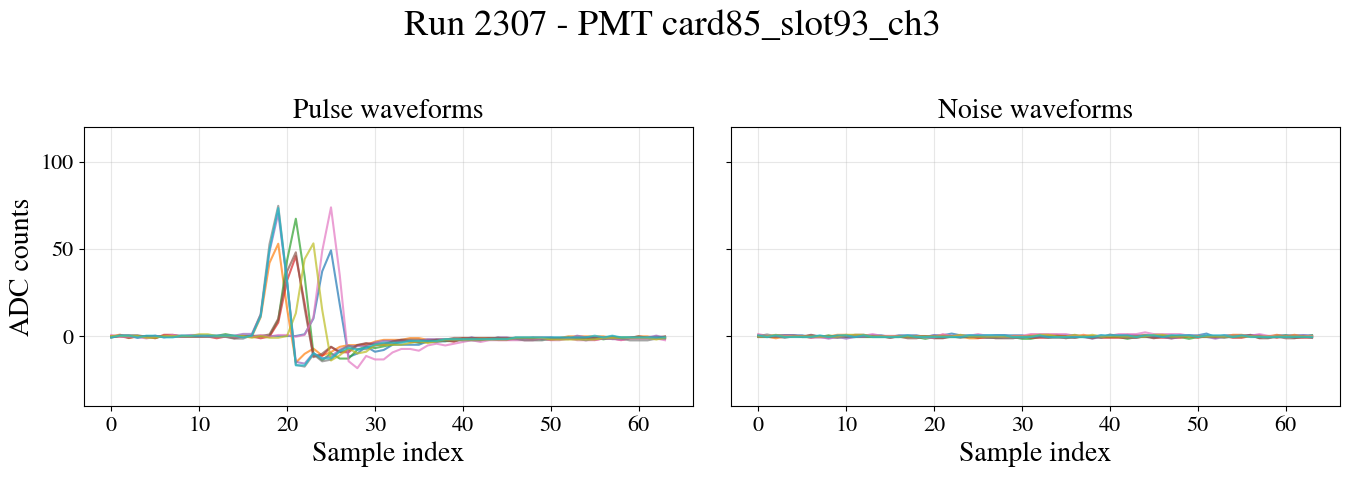

In [288]:
pulse_mask = np.zeros(len(charges), dtype=bool)
noise_mask = np.zeros(len(charges), dtype=bool)

index = 0
for wf in signal_waveforms:
    peaks = do_pulse_finding(wf)
    if len(peaks) > 0:
        pulse_mask[index] = True
    else:
        noise_mask[index] = True
    index += 1

# 10 random waveforms for each data set
pulse_indices = np.random.choice(np.where(pulse_mask)[0], size=min(10, np.sum(pulse_mask)), replace=False)
noise_indices = np.random.choice(np.where(noise_mask)[0], size=min(10, np.sum(noise_mask)), replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for idx in pulse_indices:
    axes[0].plot(signal_waveforms[idx], alpha=0.7)    #drawstyle="steps-mid"
axes[0].set_title(f"Pulse waveforms")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("ADC counts")
axes[0].grid(True, alpha=0.3)

for idx in noise_indices:
    axes[1].plot(signal_waveforms[idx], alpha=0.7)
axes[1].set_title(f"Noise waveforms")
axes[1].set_xlabel("Sample index")
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Run {run_number} - PMT {pmt_label}")
plt.ylim(-40,120)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/waveforms_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()  

/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


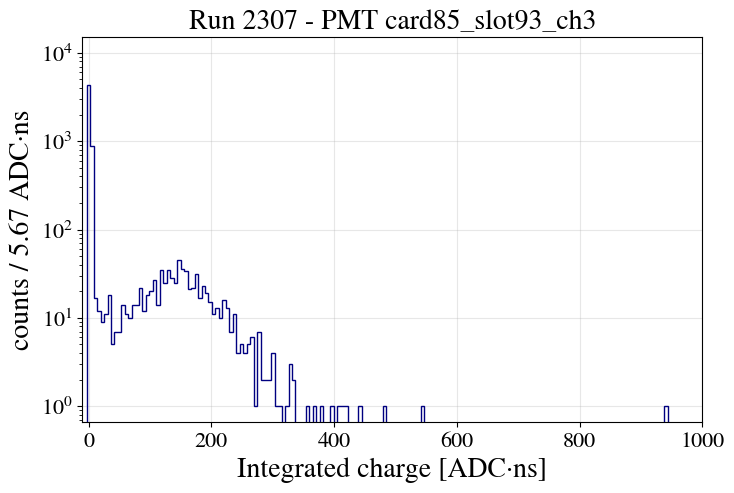

Pulse waveforms: 742 | Noise waveforms: 5258


/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


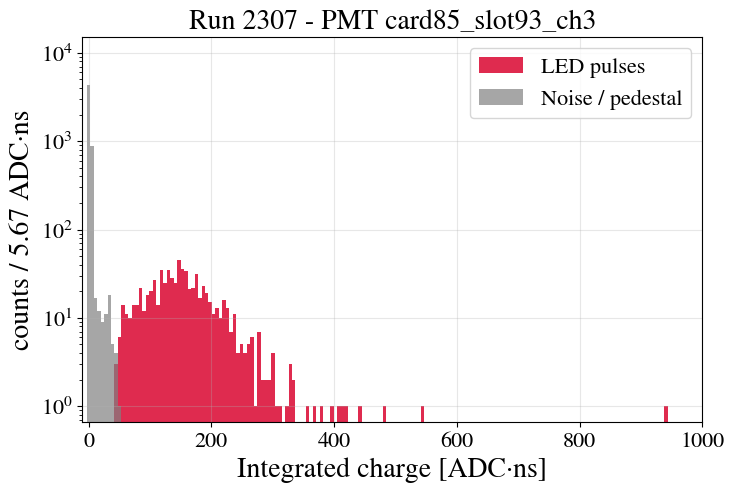

In [289]:
bins = np.linspace(charges.min(), charges.max(), 500)
bw = bins[1] - bins[0]

#total charge distribution (integrated charge)
plt.figure(figsize=(8,5))
plt.hist(charges, bins=bins, histtype='step', color='navy')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel(f"counts / {bw:.2f} ADC·ns")
plt.yscale("log")
plt.xlim(-10, 1000)
plt.ylim(0,15000)
plt.title(f"Run {run_number} - PMT {pmt_label}")
plt.grid(True, alpha=0.3)

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/integrated_charge_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()


pulse_mask = np.array([len(p) > 0 for p in all_peaks])
noise_mask = ~pulse_mask

print(f"Pulse waveforms: {np.sum(pulse_mask)} | Noise waveforms: {np.sum(noise_mask)}")

plt.figure(figsize=(8,5))
plt.hist(charges[pulse_mask], bins=bins, color='crimson', alpha=0.9, label='LED pulses')
plt.hist(charges[noise_mask], bins=bins, color='gray', alpha=0.7, label='Noise / pedestal')
plt.xlabel("Integrated charge [ADC·ns]")
plt.ylabel(f"counts / {bw:.2f} ADC·ns")
plt.yscale("log")
plt.xlim(-10, 1000)
plt.ylim(0,15000)
plt.title(f"Run {run_number} - PMT {pmt_label}")
plt.legend()
plt.grid(True, alpha=0.3)

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/integrated_charge_2_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

#print(bw) 

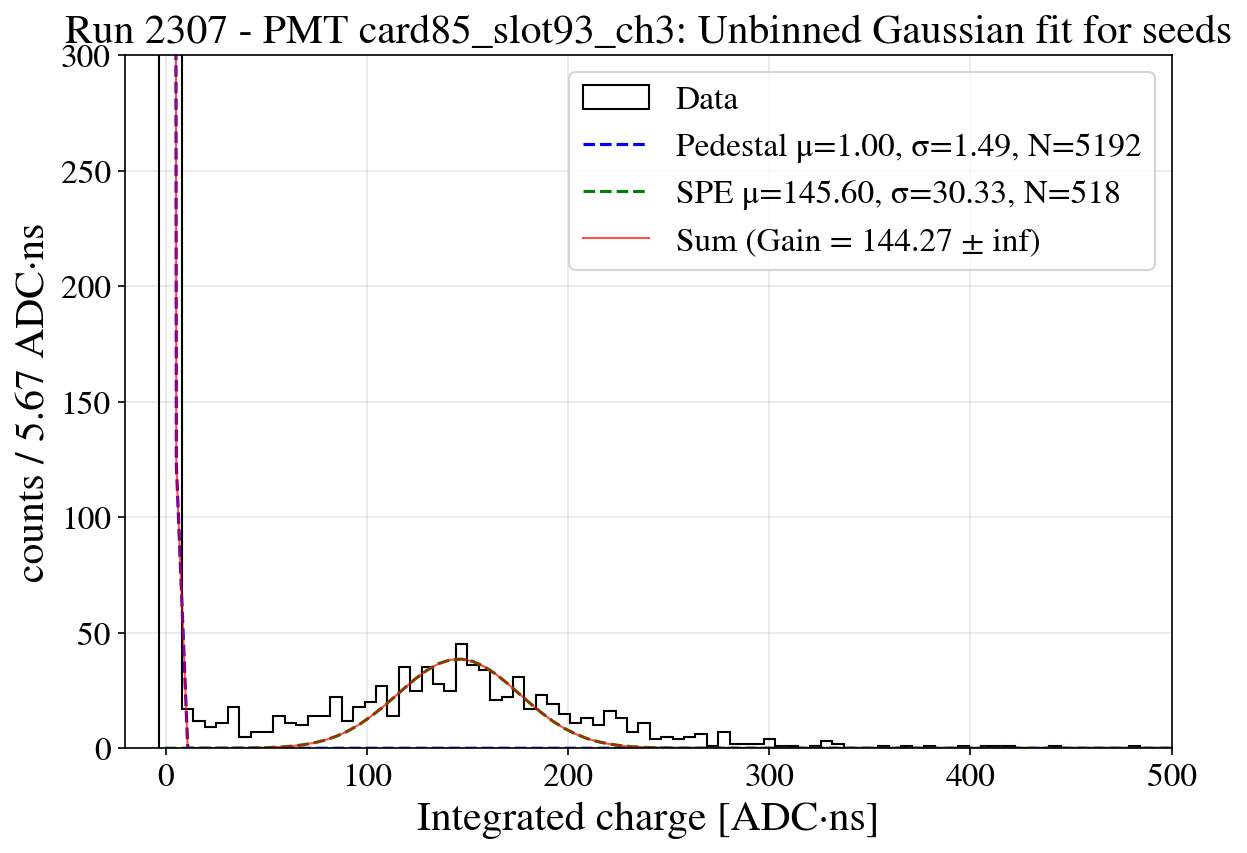


===== Pedestal Fit =====
μ₁  = 1.000  ADC·ns
σ₁  = 1.493  ADC·ns
N₁  = 5192 points

===== SPE Fit =====
μ₂  = 145.600  ADC·ns
σ₂  = 30.328  ADC·ns
N₂  = 518 points

===== Gain =====
Gain = 144.27 ± inf  ADC·ns


In [290]:
seeds = fit_pedestal_and_spe(charges, label=f"PMT {pmt_label}", plot=True)

print("\n===== Pedestal Fit =====")
print(f"μ₁  = {seeds['pedestal']['mu']:.3f}  ADC·ns")
print(f"σ₁  = {seeds['pedestal']['sigma']:.3f}  ADC·ns")
print(f"N₁  = {seeds['n_ped']} points")

print("\n===== SPE Fit =====")
print(f"μ₂  = {seeds['spe']['mu']:.3f}  ADC·ns")
print(f"σ₂  = {seeds['spe']['sigma']:.3f}  ADC·ns")
print(f"N₂  = {seeds['n_spe']} points")

print("\n===== Gain =====")
print(f"Gain = {seeds['gain']:.2f} ± {seeds['err_gain']:.2f}  ADC·ns")

/dipc/elena/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


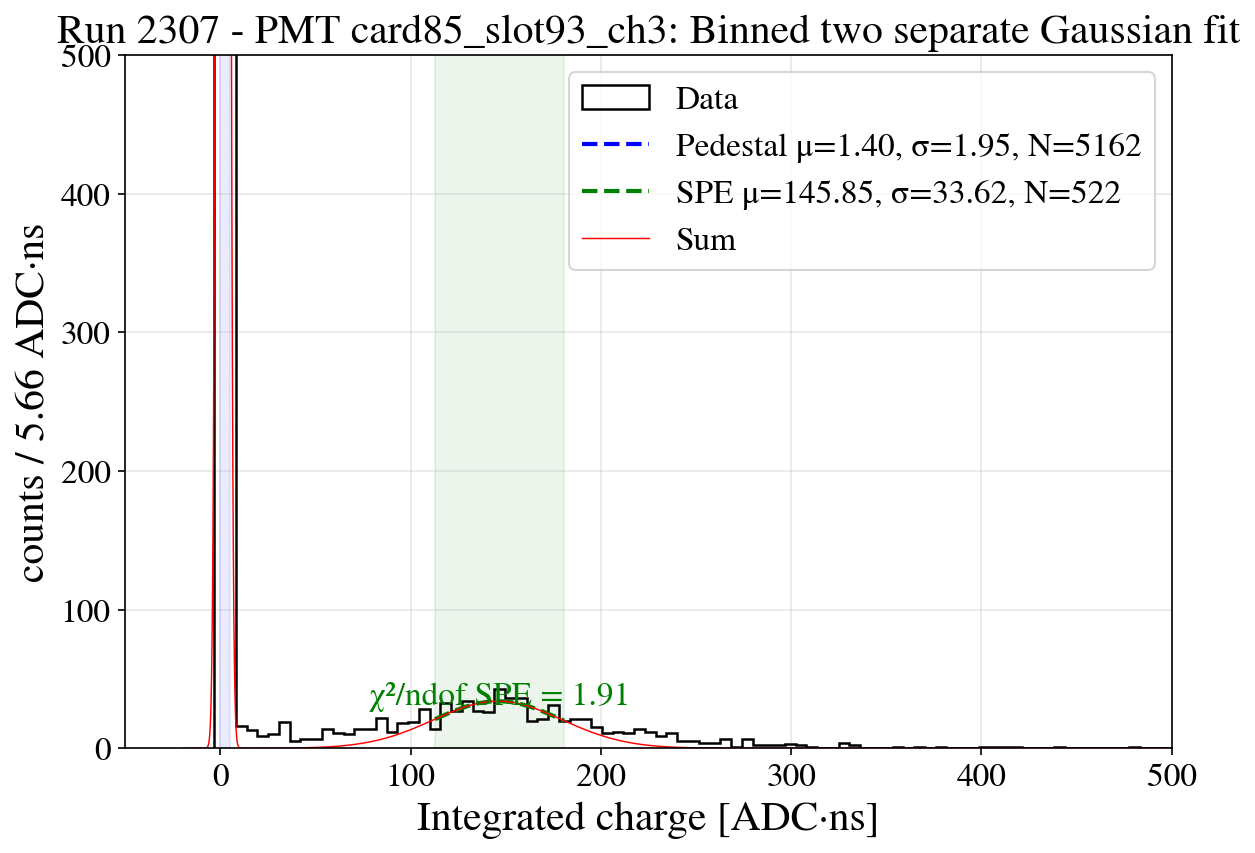


===== Pedestal Fit =====
μ₁  = 1.402  ADC·ns
σ₁  = 1.949  ADC·ns
N₁  = 5162 points
Fit region: -0.37 -> 5.29 ADC·ns

===== SPE Fit =====
μ₂  = 145.854  ADC·ns
σ₂  = 33.620  ADC·ns
N₂  = 522 points
Fit region: 112.81 -> 180.72 ADC·ns
χ²/ndof = 1.91

===== Gain =====
Gain = 144.45 ± 1.47  ADC·ns


In [291]:
results = fit_and_plot_gaussians(charges, seeds, bins=500)

mu_ped, sigma_ped, A_ped = results['pedestal']
mu_spe, sigma_spe, A_spe, chi2ndof_spe = results['spe']
gain, err_gain = results['gain']
N_ped = results['N_ped']
N_spe = results['N_spe']

print("\n===== Pedestal Fit =====")
print(f"μ₁  = {mu_ped:.3f}  ADC·ns")
print(f"σ₁  = {sigma_ped:.3f}  ADC·ns")
print(f"N₁  = {N_ped} points")
print(f"Fit region: {results['ped_region'][0]:.2f} -> {results['ped_region'][1]:.2f} ADC·ns")

print("\n===== SPE Fit =====")
print(f"μ₂  = {mu_spe:.3f}  ADC·ns")
print(f"σ₂  = {sigma_spe:.3f}  ADC·ns")
print(f"N₂  = {N_spe} points")
print(f"Fit region: {results['spe_region'][0]:.2f} -> {results['spe_region'][1]:.2f} ADC·ns")
print(f"χ²/ndof = {chi2ndof_spe:.2f}")

print("\n===== Gain =====")
print(f"Gain = {gain:.2f} ± {err_gain:.2f}  ADC·ns")

# ANALYSIS AND PLOTS FOR ALL PMTs

In [292]:
# load all npz

npz_dir = "/dipc/elena/WCTE_recovery/results/"
n_chunks = 15
#npz_files = [f"{npz_dir}High_statistics_run2307_chunk{i}.npz" for i in range(n_chunks+1)]  #1517/1567

#npz_files = [f"{npz_dir}Results_run2307_P0_chunk{i}.npz" for i in range(n_chunks+1)]   #1539/1567
#npz_files = [f"{npz_dir}Results_run2307_P1_chunk{i}.npz" for i in range(n_chunks+1)]  #1524/1567

#npz_files = [f"{npz_dir}Results_run2306_chunk{i}.npz" for i in range(n_chunks+1)]    #1549


npz_files = [f"{npz_dir}Final_run2307_chunk{i}.npz" for i in range(n_chunks+1)]




all_results_list = []
for npz_file in npz_files:
    data_chunk = np.load(npz_file)["results"]
    all_results_list.append(data_chunk)

# Concatante chunks
results = np.concatenate(all_results_list)

len(results)

1567

In [293]:
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results:
    key = (r["card_id"], r["slot_id"])
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(pmt_labels))

# Gain and errors
gains = results["gain"].astype(float)
pedestal_sigma = results["pedestal_sigma"].astype(float)
spe_sigma = results["spe_sigma"].astype(float)
N_pedestal = results["N_pedestal"].astype(float)
N_spe = results["N_spe"].astype(float)

# Avoid division by 0
N_pedestal[N_pedestal == 0] = np.nan
N_spe[N_spe == 0] = np.nan

gain_errors = np.sqrt((pedestal_sigma/np.sqrt(N_pedestal))**2 + (spe_sigma/np.sqrt(N_spe))**2)

mask = np.isfinite(gains) & np.isfinite(gain_errors)
y_min = np.min(gains[mask] - gain_errors[mask]) * 0.95
y_max = np.max(gains[mask] + gain_errors[mask]) * 1.05


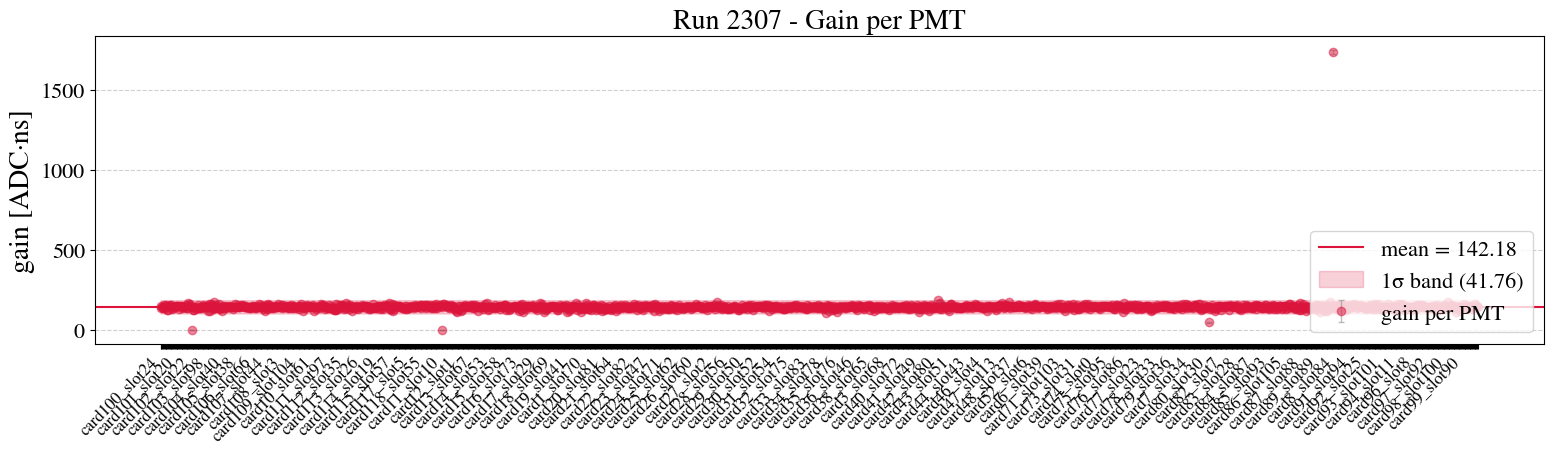

In [295]:
# Gain scatter plot
fig, ax = plt.subplots(figsize=(16,5))
color = "crimson"
marker_alpha = 0.5  #

eb = ax.errorbar(
    x, gains, yerr=gain_errors,
    fmt='o', color=color, ecolor='gray',
    elinewidth=1, capsize=2,
    alpha=marker_alpha, 
    label="gain per PMT"
)

mean_gain = np.nanmean(gains)
std_gain = np.nanstd(gains)

ax.axhline(mean_gain, color=color, lw=1.5, label=f"mean = {mean_gain:.2f}")
ax.fill_between(x, mean_gain-std_gain, mean_gain+std_gain, color=color, alpha=0.2,label=f"1σ band ({std_gain:.2f})")

run_number=2307
part_file = "0"

ax.set_xticks(ticks=x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylabel("gain [ADC·ns]")
ax.set_title(f"Run {run_number} - Gain per PMT")
ax.legend(loc="lower right")
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/gain_per_PMT_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 


plt.show()

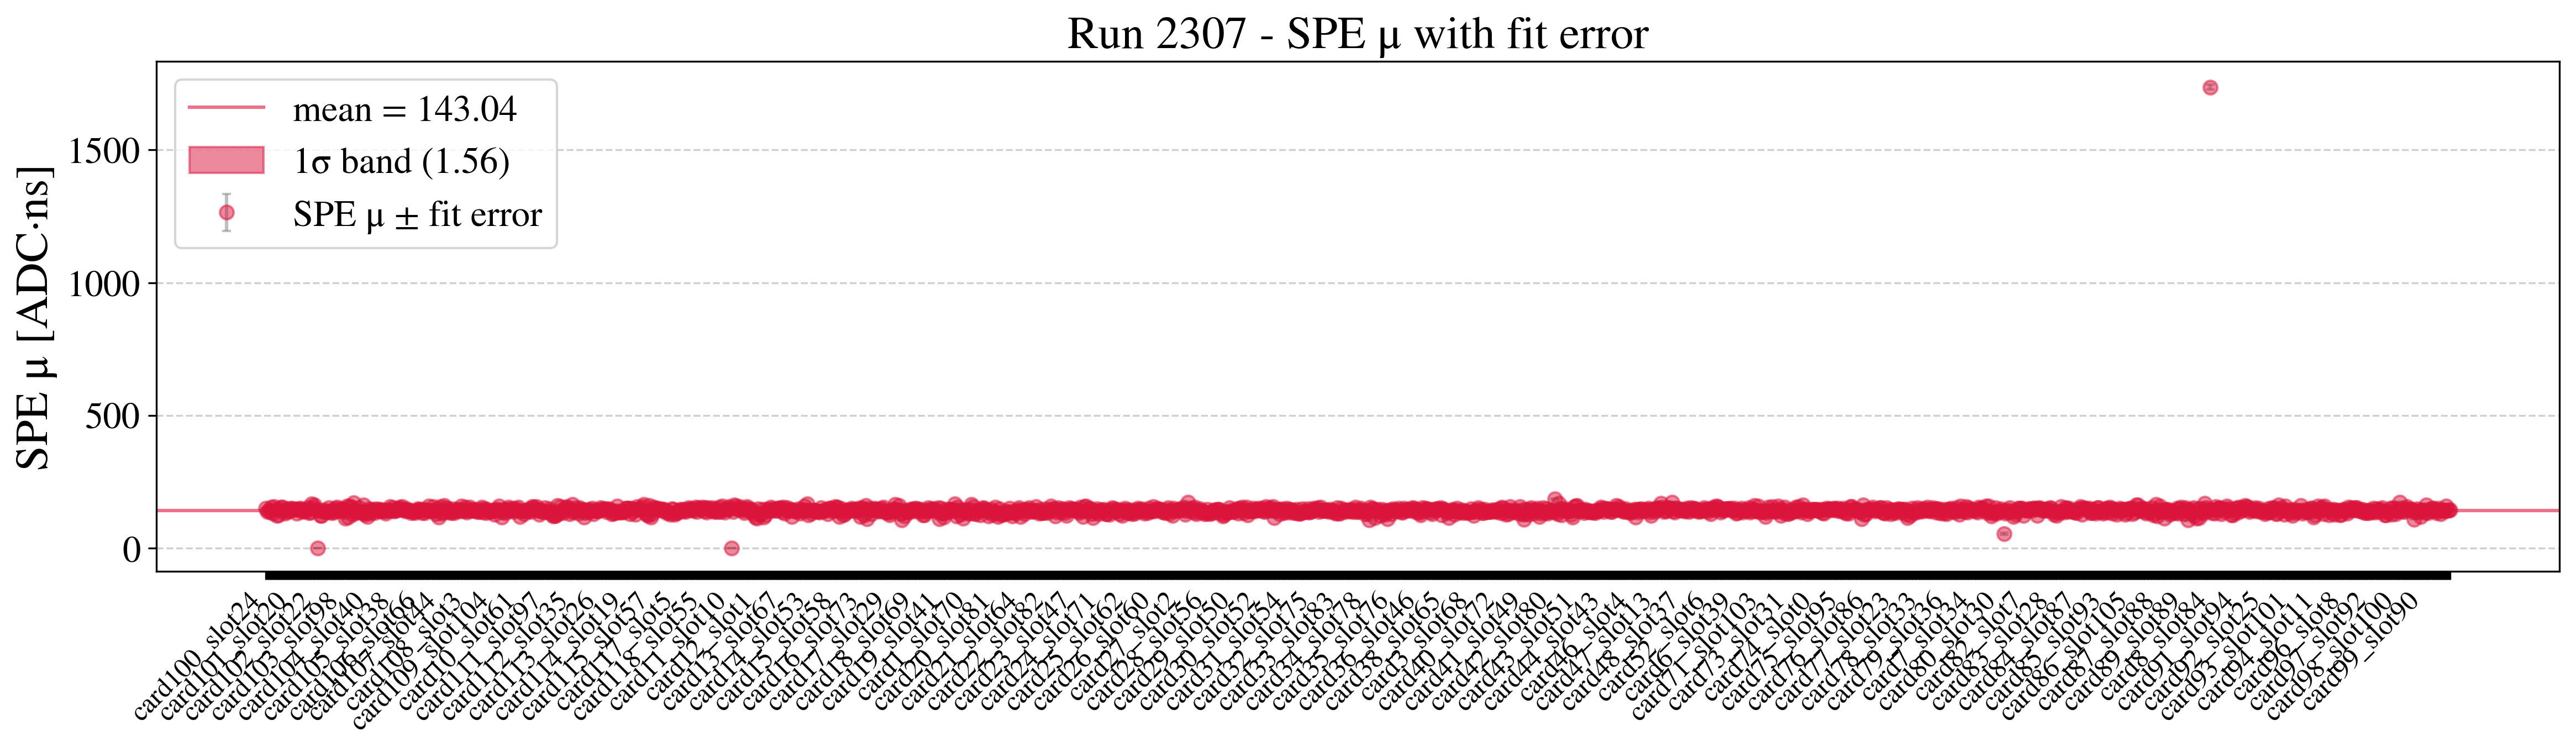

[1.66262415 1.04476553 1.1446937  ... 1.37039199 1.93542887 1.38586565]


In [296]:
mu_ped = results['pedestal_mean'].astype(float)
sigma_ped = results['pedestal_sigma'].astype(float)
mu_spe = results['spe_mean'].astype(float)
sigma_spe = results['spe_sigma'].astype(float)


err_mu_spe = sigma_spe / np.sqrt(N_spe)  

fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.errorbar(x, mu_spe, yerr=err_mu_spe, fmt='o', color='crimson', alpha=0.5, ecolor='gray', capsize=2, label='SPE μ ± fit error')

mean_mu_spe = np.nanmean(mu_spe)   #mean value of mu_spe
sigma_mu_spe = np.sqrt(np.nansum(err_mu_spe**2) / len(err_mu_spe))    #1sigma band calculated with statistical uncertainties

ax.axhline(mean_mu_spe, color='crimson', lw=1.5, alpha=0.6, label=f"mean = {mean_mu_spe:.2f}")
ax.fill_between(x, mean_mu_spe-sigma_mu_spe, mean_mu_spe+sigma_mu_spe, color='crimson', alpha=0.5, label=f"1σ band ({sigma_mu_spe:.2f})")


ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("SPE μ [ADC·ns]")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_title(f"Run {run_number} - SPE μ with fit error")
ax.legend()
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_per_PMT_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

print(err_mu_spe)

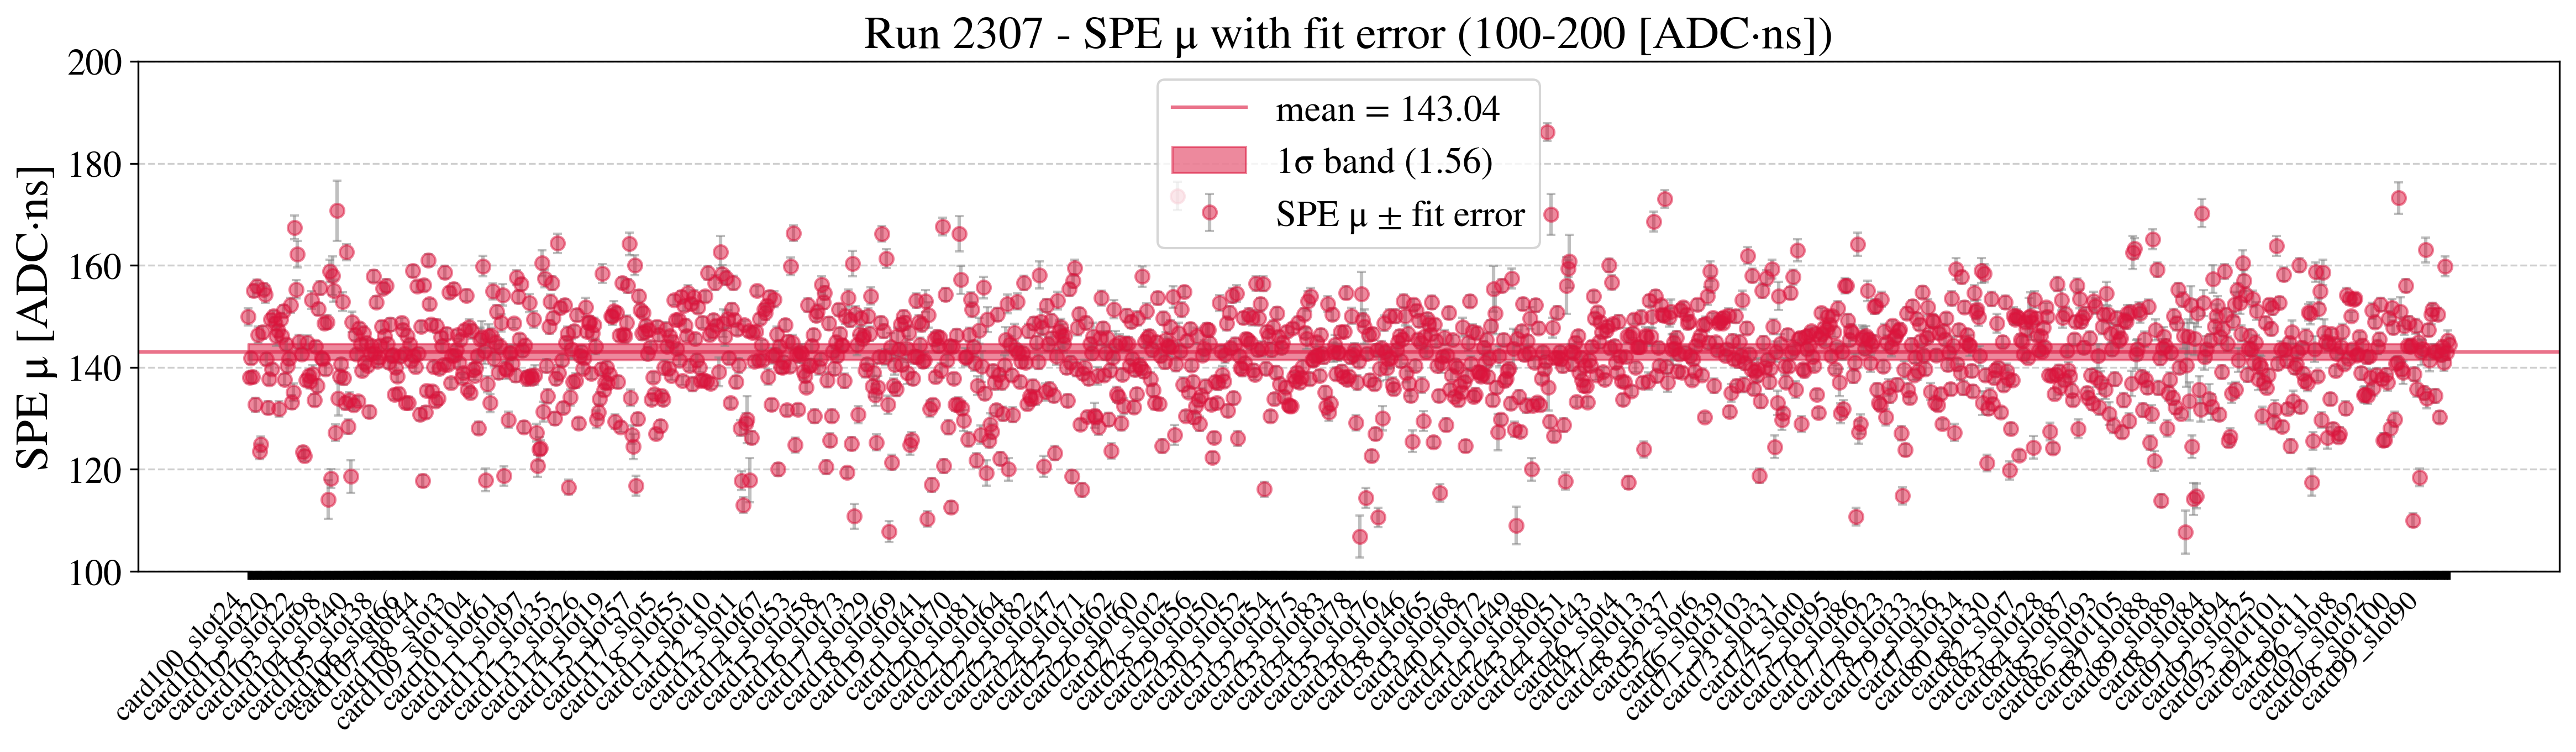

[1.66262415 1.04476553 1.1446937  ... 1.37039199 1.93542887 1.38586565]


In [297]:
mu_ped = results['pedestal_mean'].astype(float)
sigma_ped = results['pedestal_sigma'].astype(float)
mu_spe = results['spe_mean'].astype(float)
sigma_spe = results['spe_sigma'].astype(float)


err_mu_spe = sigma_spe / np.sqrt(N_spe)  

fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.errorbar(x, mu_spe, yerr=err_mu_spe, fmt='o', color='crimson', alpha=0.5, ecolor='gray', capsize=2, label='SPE μ ± fit error')

mean_mu_spe = np.nanmean(mu_spe)   #mean value of mu_spe
sigma_mu_spe = np.sqrt(np.nansum(err_mu_spe**2) / len(err_mu_spe))    #1sigma band calculated with statistical uncertainties

ax.axhline(mean_mu_spe, color='crimson', lw=1.5, alpha=0.6, label=f"mean = {mean_mu_spe:.2f}")
ax.fill_between(x, mean_mu_spe-sigma_mu_spe, mean_mu_spe+sigma_mu_spe, color='crimson', alpha=0.5, label=f"1σ band ({sigma_mu_spe:.2f})")

ymin =100
ymax = 200
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("SPE μ [ADC·ns]")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylim(ymin, ymax)
ax.set_title(f"Run {run_number} - SPE μ with fit error ({ymin}-{ymax} [ADC·ns])")
ax.legend()
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_per_PMT_range_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

print(err_mu_spe)

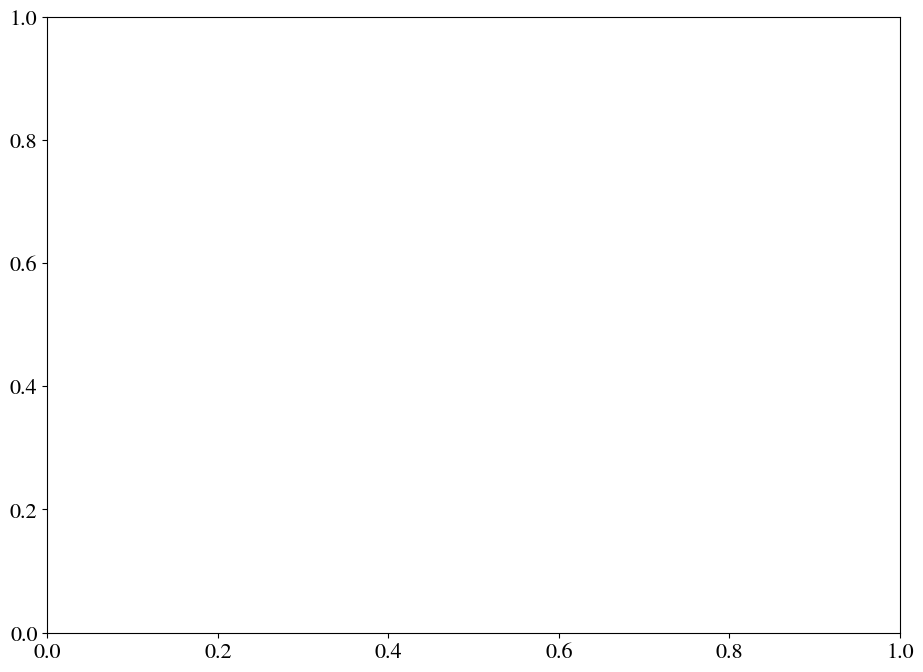

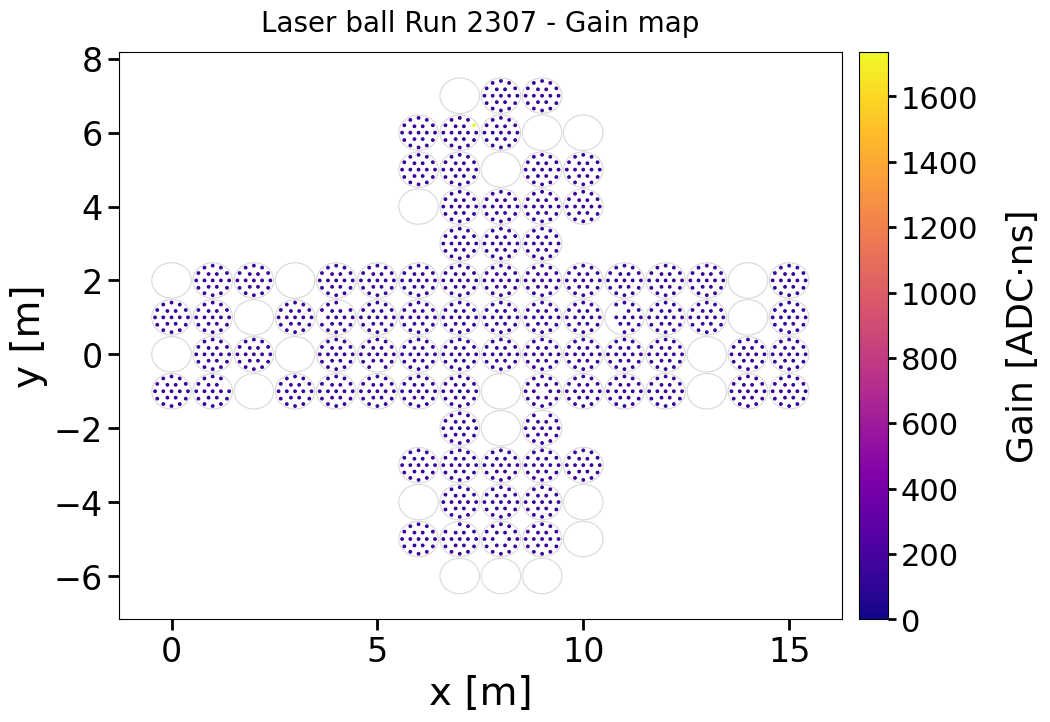

In [298]:
# Initialization EventDisplay
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)

from EventDisplay import EventDisplay

ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

gain_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

# Plot
fig, ax = plt.subplots(figsize=(11,8))
ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel), vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=11,
    show_zero=True,
    style=None
)
plt.gca().set_title(f"Laser ball Run {run_number} - Gain map", fontsize=20, pad=15)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/gain_map_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 
plt.show()

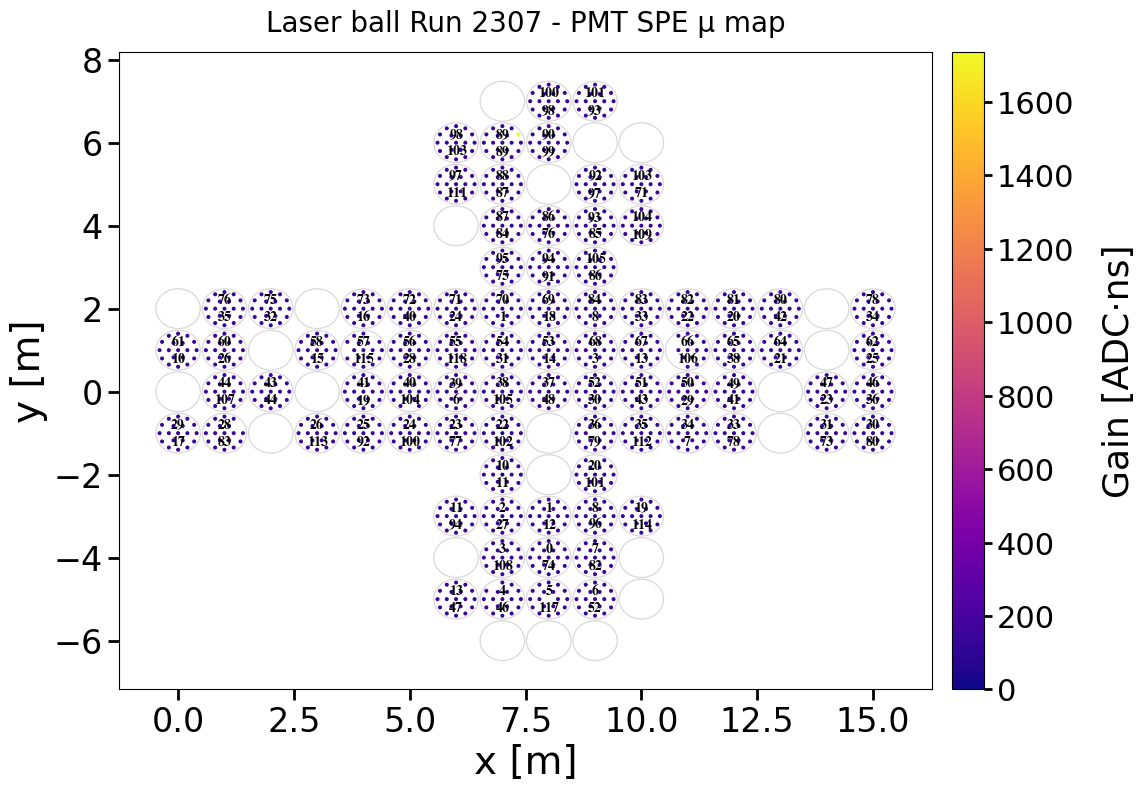

In [299]:
# Create array of gains per channel
gain_per_channel = np.full(ed.nChannels, np.nan)

# Fill gain_per_channel
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


ed.plotEventDisplay(
    data=gain_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=np.nanmin(gain_per_channel),
                                vmax=np.nanmax(gain_per_channel)),
    color_label="Gain [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

#----------------- ADD SLOT AND CARD LABELS -----------------
for mPMT_idx, (x, y) in enumerate(ed.mPMT_2D_projection[:, 1:3]):
    # Filter all channels of this mPMT
    entries = results[results['slot_id'] == mPMT_idx]
    if len(entries) == 0:
        continue
    slot_id = entries['slot_id'][0]
    card_id = entries['card_id'][0]

    # Plot slot and card IDs above and below each mPMT position
    plt.text(x, y + 0.05, str(slot_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='bottom')
    plt.text(x, y - 0.05, str(card_id), color='k', fontsize=10, fontweight='bold',
             ha='center', va='top')

plt.gca().set_title(f"Laser ball Run {run_number} - PMT SPE μ map", fontsize=20, pad=15)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_map_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

In [270]:
print(results.dtype)

[('card_id', '<i4'), ('slot_id', '<i4'), ('channel_id', '<i4'), ('pos_id', '<i4'), ('pedestal_mean', '<f8'), ('pedestal_sigma', '<f8'), ('N_pedestal', '<i4'), ('spe_mean', '<f8'), ('spe_sigma', '<f8'), ('N_spe', '<i4'), ('gain', '<f8'), ('gain_error', '<f8'), ('pulse_ratio', '<f8'), ('mu_pe', '<f8'), ('chi2ndof_spe', '<f8'), ('fit_failed', '?')]


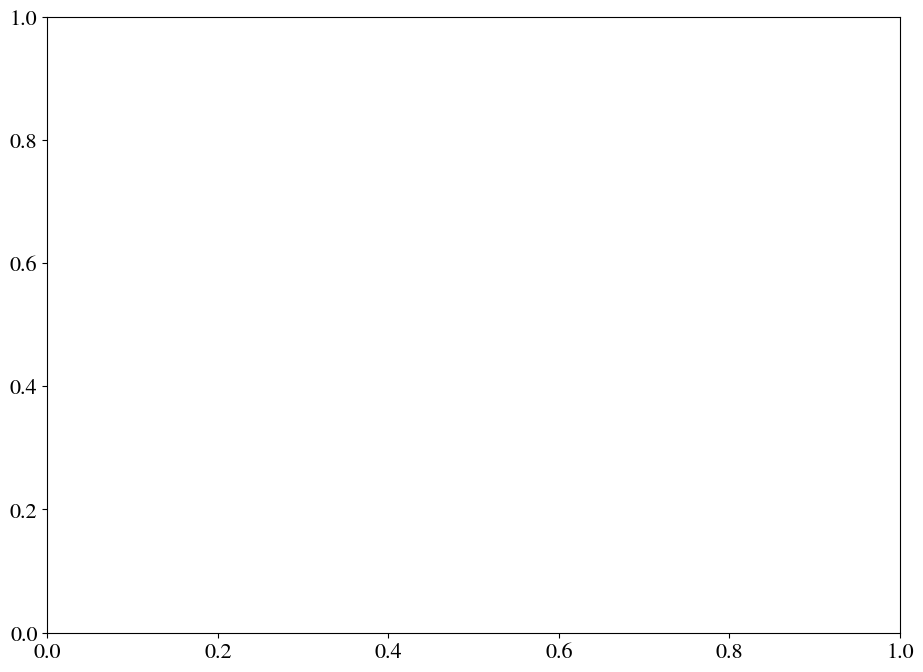

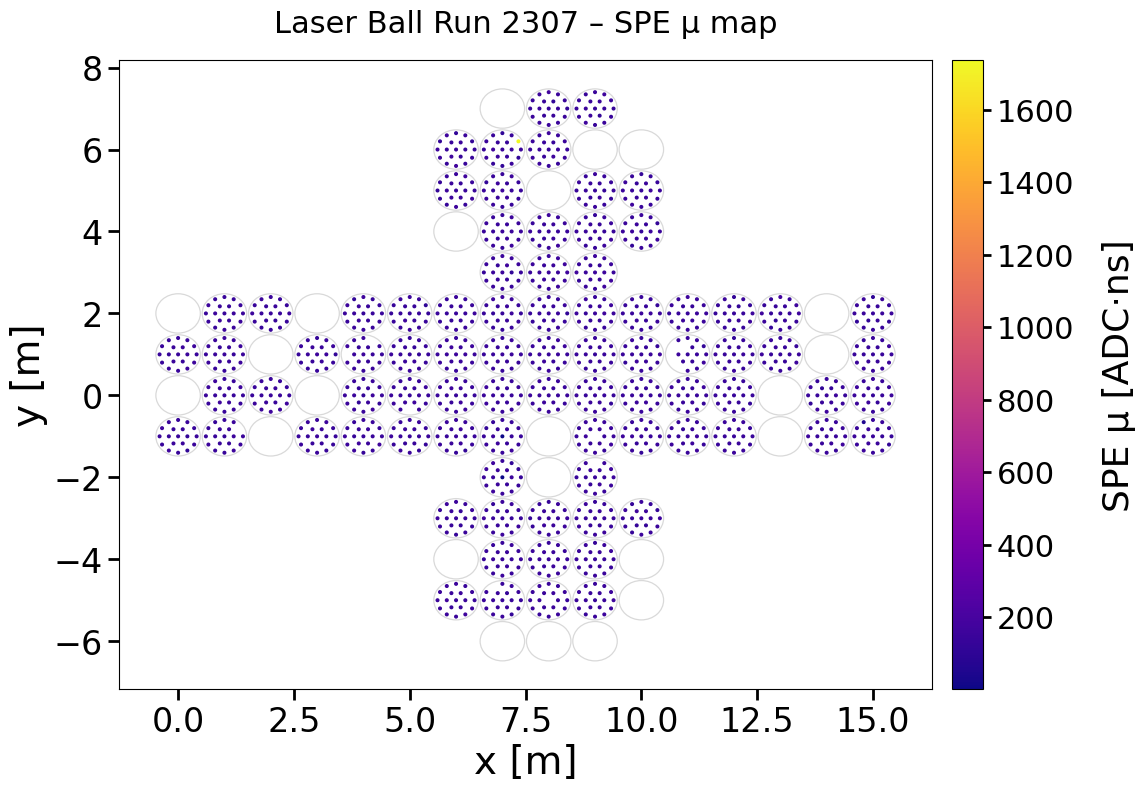

In [300]:
# --------------------------
# Initialization EventDisplay
# --------------------------
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)

from EventDisplay import EventDisplay
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# --------------------------
# Optional: your STIX formatting
# --------------------------
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

# --------------------------
# Load EventDisplay
# --------------------------
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# --------------------------
# Build μ_spe per channel
# --------------------------
mu_spe_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry["card_id"])
    slot = int(entry["slot_id"])
    ch   = int(entry["channel_id"])
    mu_spe = float(entry["spe_mean"])  # <--- ensure this matches your stored key name

    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        mu_spe_per_channel[idx] = mu_spe

# --------------------------
# Automatic color range (or choose your own)
# --------------------------
vmin = np.nanmin(mu_spe_per_channel)
vmax = np.nanmax(mu_spe_per_channel)

# --------------------------
# Plot EventDisplay of μ_spe
# --------------------------
fig, ax = plt.subplots(figsize=(11, 8))

ed.plotEventDisplay(
    data=mu_spe_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=vmin, vmax=vmax),
    color_label="SPE μ [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.title(f"Laser Ball Run {run_number} – SPE μ map", fontsize=22, pad=20)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_map_2_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

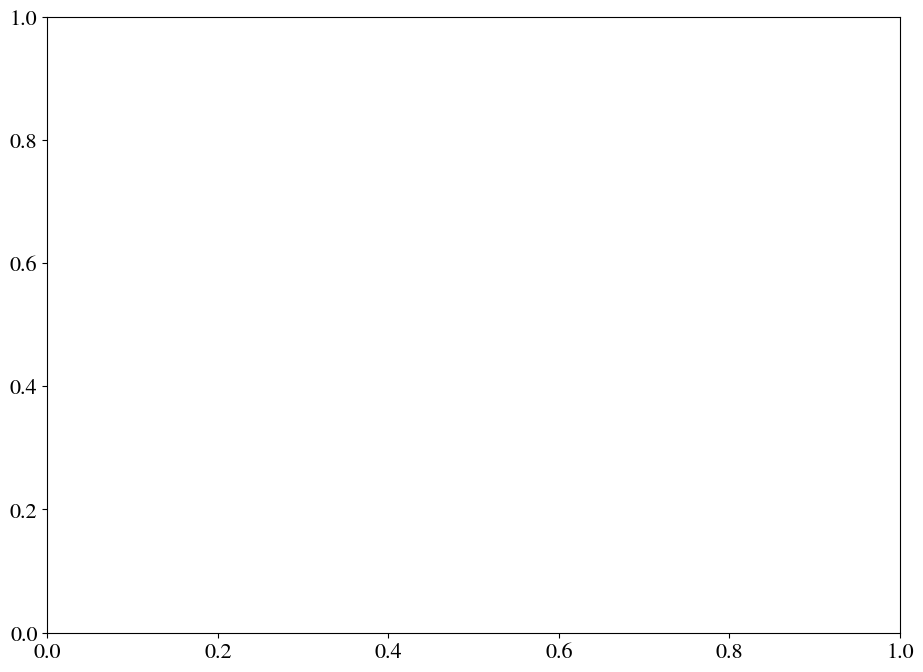

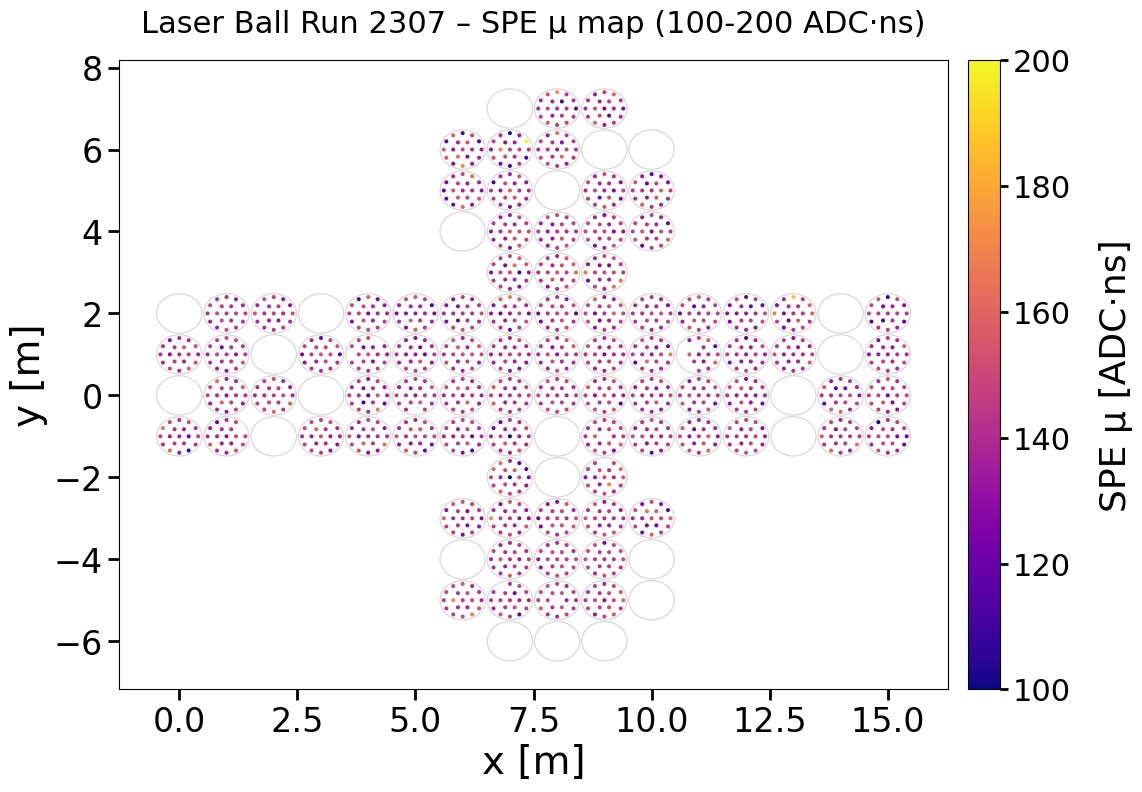

In [301]:
# --------------------------
# Initialization EventDisplay
# --------------------------
wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)

from EventDisplay import EventDisplay
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# --------------------------
# Optional: your STIX formatting
# --------------------------
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [11, 8]
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

# --------------------------
# Load EventDisplay
# --------------------------
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")

# --------------------------
# Build μ_spe per channel
# --------------------------
mu_spe_per_channel = np.full(ed.nChannels, np.nan)

for entry in results:
    card = int(entry["card_id"])
    slot = int(entry["slot_id"])
    ch   = int(entry["channel_id"])
    mu_spe = float(entry["spe_mean"])  

    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        mu_spe_per_channel[idx] = mu_spe

# --------------------------
# FIXED color scale: 130 → 160
# --------------------------
vmin = 100
vmax = 200

# --------------------------
# Plot EventDisplay of μ_spe
# --------------------------
fig, ax = plt.subplots(figsize=(11, 8))

ed.plotEventDisplay(
    data=mu_spe_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=vmin, vmax=vmax),
    color_label="SPE μ [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

plt.title(f"Laser Ball Run {run_number} – SPE μ map ({vmin}-{vmax} ADC·ns)", fontsize=22, pad=20)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_map_range_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 
plt.show()

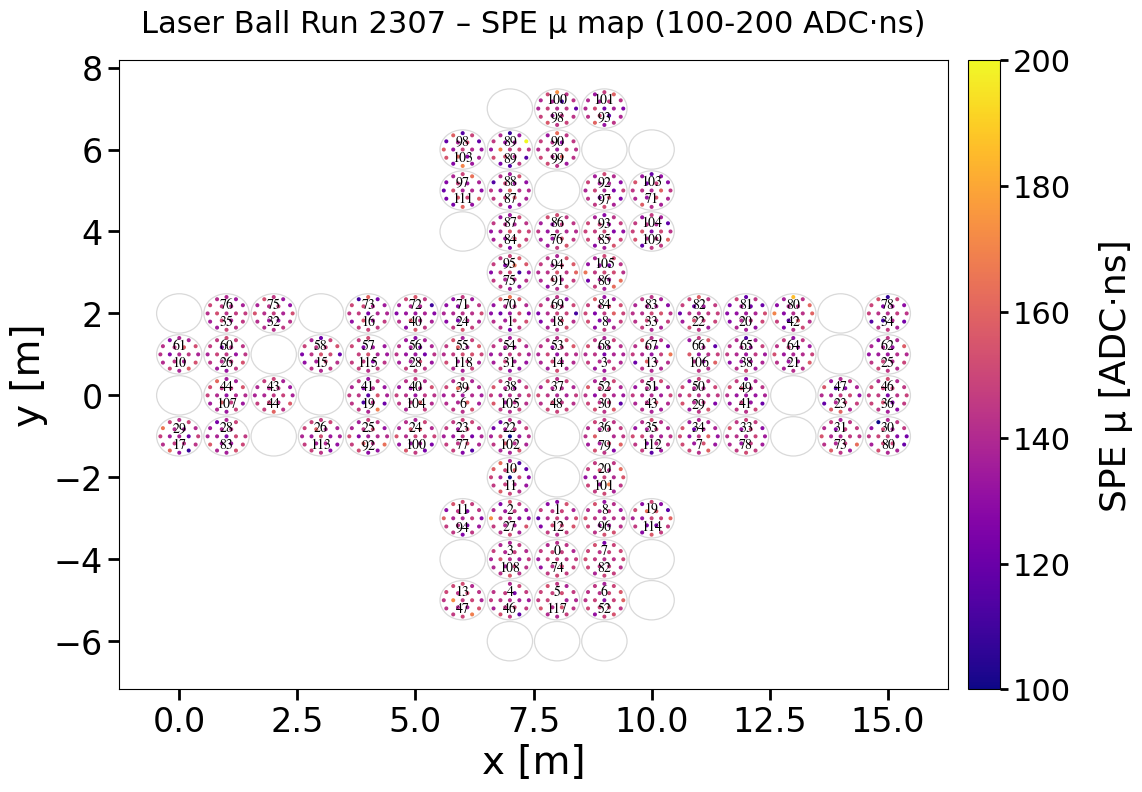

In [302]:
# Create array of gains per channel
gain_per_channel = np.full(ed.nChannels, np.nan)

# Fill gain_per_channel
for entry in results:
    card = int(entry['card_id'])
    slot = int(entry['slot_id'])
    ch   = int(entry['channel_id'])
    gain = float(entry['gain'])
    
    mPMT_id = slot
    idx = 19 * mPMT_id + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain

vmin = 100
vmax = 200

ed.plotEventDisplay(
    data=mu_spe_per_channel,
    color_map=plt.cm.plasma,
    color_norm=colors.Normalize(vmin=vmin, vmax=vmax),
    color_label="SPE μ [ADC·ns]",
    fig_width=12,
    show_zero=True,
    style=None
)

#----------------- ADD SLOT AND CARD LABELS -----------------
for mPMT_idx, (x, y) in enumerate(ed.mPMT_2D_projection[:, 1:3]):
    # Filter all channels of this mPMT
    entries = results[results['slot_id'] == mPMT_idx]
    if len(entries) == 0:
        continue
    slot_id = entries['slot_id'][0]
    card_id = entries['card_id'][0]

    # Plot slot and card IDs above and below each mPMT position
    plt.text(x, y + 0.05, str(slot_id), color='k', fontsize=10,
             ha='center', va='bottom')
    plt.text(x, y - 0.05, str(card_id), color='k', fontsize=10,
             ha='center', va='top')

plt.title(f"Laser Ball Run {run_number} – SPE μ map ({vmin}-{vmax} ADC·ns)", fontsize=22, pad=20)
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/SPE_mean_map_range_2_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

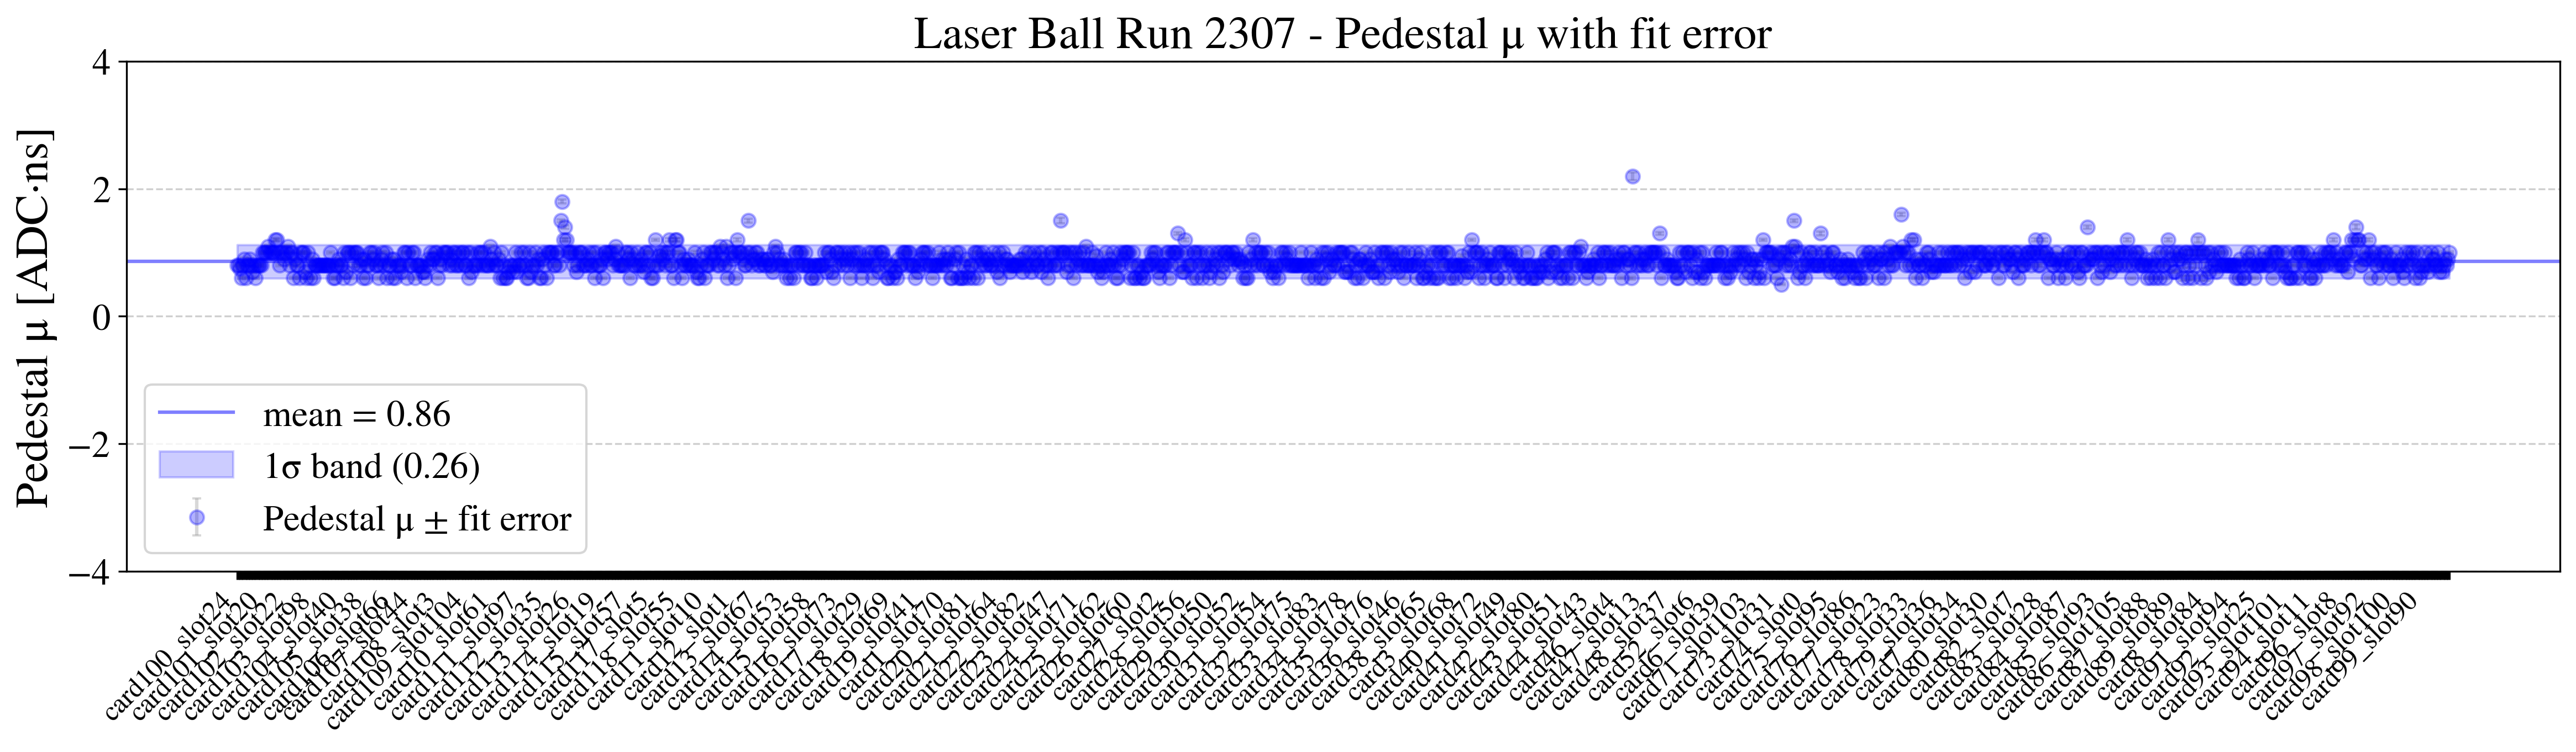

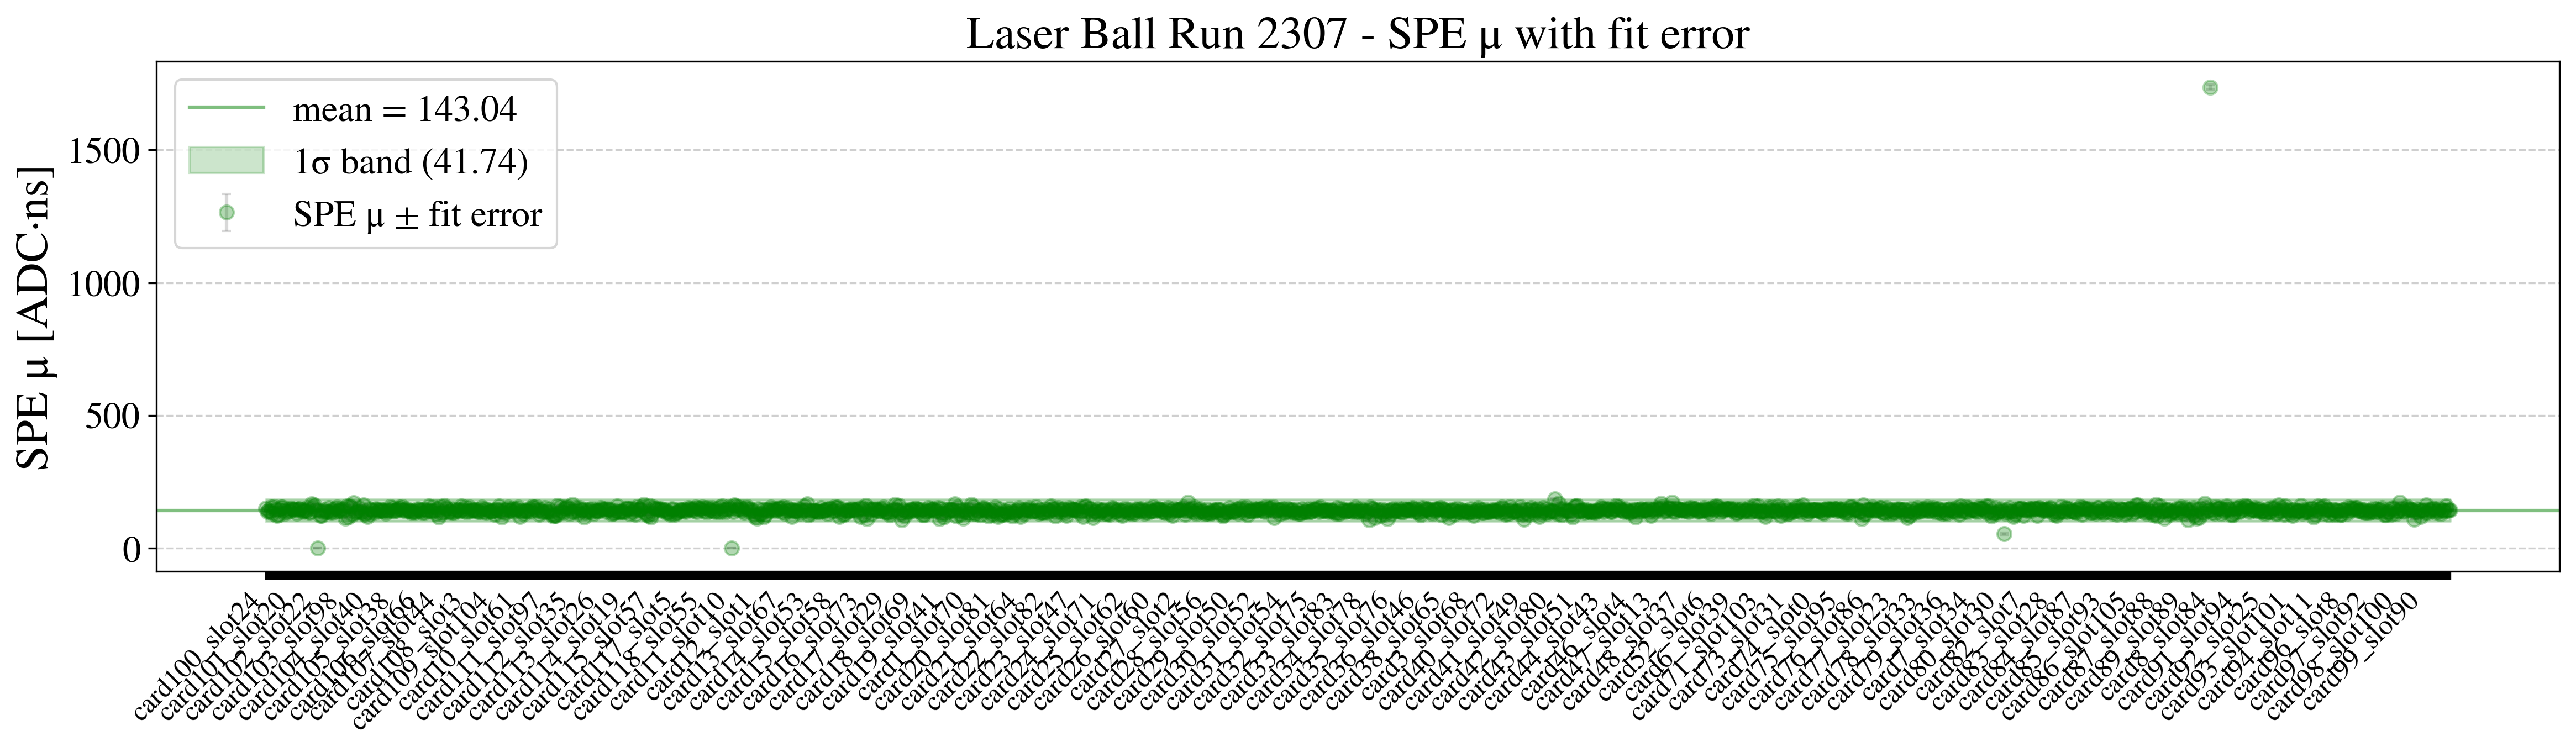

In [304]:
mu_ped = results['pedestal_mean'].astype(float)
sigma_ped = results['pedestal_sigma'].astype(float)
mu_spe = results['spe_mean'].astype(float)
sigma_spe = results['spe_sigma'].astype(float)

# x-axis labels
pmt_labels = []
x_labels = []
seen_mpmt = set()
for r in results:
    key = (r['card_id'], r['slot_id'])  # mPMT identifier
    if key not in seen_mpmt:
        x_labels.append(f"card{r['card_id']}_slot{r['slot_id']}")
        seen_mpmt.add(key)
    else:
        x_labels.append("")
    pmt_labels.append(f"{r['card_id']}_{r['slot_id']}_{r['channel_id']}")

x = np.arange(len(results))  # one x per PMT


# ----------------Pedestal μ ± σ-----------------------

fig, ax = plt.subplots(figsize=(16,5), dpi=300)
err_mu_ped = sigma_ped / np.sqrt(N_pedestal)
ax.errorbar(x, mu_ped, yerr=err_mu_ped, fmt='o', color='blue', alpha=0.3, ecolor='gray', capsize=2, label='Pedestal μ ± fit error')


mean_mu_ped = np.nanmean(mu_ped)
std_mu_ped = np.nanstd(mu_ped)
ax.axhline(mean_mu_ped, color='blue', lw=1.5,  alpha=0.5, label=f"mean = {mean_mu_ped:.2f}")
ax.fill_between(x, mean_mu_ped-std_mu_ped, mean_mu_ped+std_mu_ped, color='blue', alpha=0.2, label=f"1σ band ({std_mu_ped:.2f})")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("Pedestal μ [ADC·ns]")
ax.set_ylim(-4,4)
ax.set_title(f"Laser Ball Run {run_number} - Pedestal μ with fit error")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/pedestal_fit_per_PMT_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 


plt.show()


# ---------------SPE μ ± σ---------------------

fig, ax = plt.subplots(figsize=(16,5), dpi=300)
err_mu_spe = sigma_spe / np.sqrt(N_spe)  # or directly use the fit-provided error if available
ax.errorbar(x, mu_spe, yerr=err_mu_spe, fmt='o', color='green', alpha=0.3, ecolor='gray', capsize=2, label='SPE μ ± fit error')

mean_mu_spe = np.nanmean(mu_spe)
std_mu_spe = np.nanstd(mu_spe)
ax.axhline(mean_mu_spe, color='green', lw=1.5, alpha=0.5, label=f"mean = {mean_mu_spe:.2f}")
ax.fill_between(x, mean_mu_spe-std_mu_spe, mean_mu_spe+std_mu_spe, color='green', alpha=0.2, label=f"1σ band ({std_mu_spe:.2f})")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("SPE μ [ADC·ns]")
ax.set_title(f"Laser Ball Run {run_number} - SPE μ with fit error")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

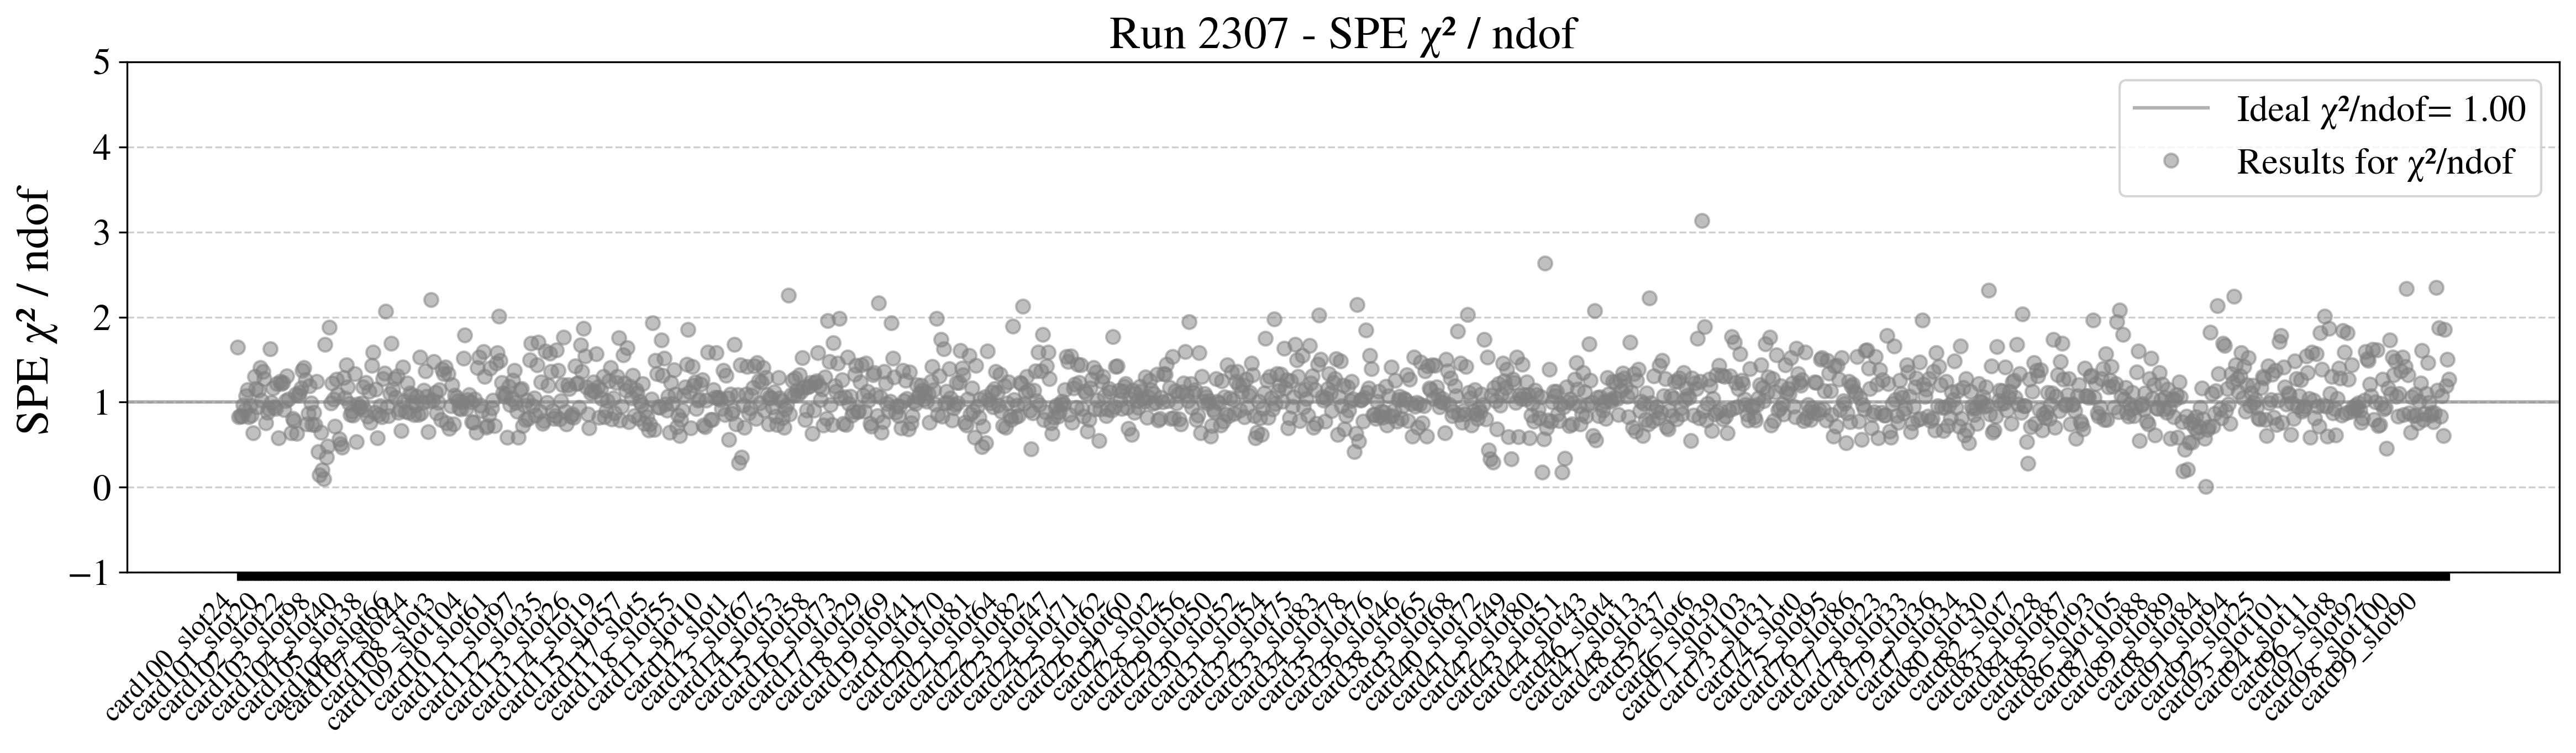

In [305]:
chi2ndof_spe=results["chi2ndof_spe"].astype(float)
chi2_ideal = 1

fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.errorbar(x, chi2ndof_spe, fmt='o', color='gray', alpha=0.5, ecolor='gray', capsize=2, label='Results for χ²/ndof ')
ax.axhline(chi2_ideal, color='gray', lw=1.5,  alpha=0.6, label=f"Ideal χ²/ndof= {chi2_ideal:.2f}")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)
ax.set_ylabel(" SPE χ² / ndof")
ax.set_title(f"Run {run_number} - SPE χ² / ndof")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylim(-1,5)
ax.legend()
plt.tight_layout()

save_path = f"/scratch/elena/WCTE_recovery/plots/run2307/chi2ndof_spe_per_PMT_Run{run_number}_PMT{pmt_label}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight') 

plt.show()

#print(results["chi2ndof_spe"])


In [276]:
diff = chi2ndof_spe-chi2_ideal
chi2ndof_spe=results["chi2ndof_spe"].astype(float)

top_above_indices = np.argsort(-diff)[:10]  
top_below_indices = np.argsort(diff)[:10]  

print(f"Top 10 PMTs most above χ²/ndof")
for idx in top_above_indices:
    card_id, slot_id, channel_id = pmt_labels[idx].split('_')
    print(f"card{card_id}_slot{slot_id}_ch{channel_id} | χ²/ndof = {chi2ndof_spe[idx]:.2f} | Δ = {diff[idx]:.2f} ADC·ns | ")

print(f"\nTop 10 PMTs most below χ²/ndof")
for idx in top_below_indices:
    card_id, slot_id, channel_id = pmt_labels[idx].split('_')
    print(f"card{card_id}_slot{slot_id}_ch{channel_id} | χ²/ndof = {chi2ndof_spe[idx]:.2f} | Δ = {diff[idx]:.2f} ADC·ns |")


Top 10 PMTs most above χ²/ndof
card11_slot10_ch0 | χ²/ndof = 38.86 | Δ = 37.86 ADC·ns | 
card52_slot6_ch10 | χ²/ndof = 3.13 | Δ = 2.13 ADC·ns | 
card42_slot80_ch12 | χ²/ndof = 2.63 | Δ = 1.63 ADC·ns | 
card99_slot90_ch18 | χ²/ndof = 2.35 | Δ = 1.35 ADC·ns | 
card98_slot100_ch16 | χ²/ndof = 2.33 | Δ = 1.33 ADC·ns | 
card7_slot34_ch6 | χ²/ndof = 2.32 | Δ = 1.32 ADC·ns | 
card13_slot67_ch9 | χ²/ndof = 2.26 | Δ = 1.26 ADC·ns | 
card8_slot84_ch9 | χ²/ndof = 2.25 | Δ = 1.25 ADC·ns | 
card47_slot13_ch11 | χ²/ndof = 2.23 | Δ = 1.23 ADC·ns | 
card107_slot44_ch2 | χ²/ndof = 2.20 | Δ = 1.20 ADC·ns | 

Top 10 PMTs most below χ²/ndof
card89_slot89_ch8 | χ²/ndof = 0.01 | Δ = -0.99 ADC·ns |
card103_slot98_ch14 | χ²/ndof = 0.10 | Δ = -0.90 ADC·ns |
card103_slot98_ch11 | χ²/ndof = 0.14 | Δ = -0.86 ADC·ns |
card42_slot80_ch10 | χ²/ndof = 0.18 | Δ = -0.82 ADC·ns |
card42_slot80_ch6 | χ²/ndof = 0.18 | Δ = -0.82 ADC·ns |
card89_slot89_ch10 | χ²/ndof = 0.19 | Δ = -0.81 ADC·ns |
card103_slot98_ch13 | χ²/ndof